
This Python code conducts data preprocessing, logistic regression modeling, and visual representation of results across three distinct datasets: MTurk, DTU1, and DTU2. 

Initially, the data from three Excel files are loaded into separate pandas DataFrames (df_MTurk, df_DTU1, and df_DTU2), and columns with unnamed headers are removed. The arrival times for each dataset are then standardized to equidistant intervals, measured in minutes from 8:00 AM, to facilitate subsequent analysis. The datasets are concatenated into a single DataFrame (df), with an additional categorical variable, group, used to label the dataset origin (MTurk, DTU1, or DTU2). 

To model the relationship between arrival time and the probability of choosing the canteen (choice), a logistic regression is performed using seaborn’s lmplot. This function is designed for visualizing the fit of a regression model, and in this case, it computes a logistic regression (binomial model) with bootstrapped confidence intervals (CI = 95%) for the estimated parameters. Bootstrapping is performed with n_boot=10000 iterations to ensure stable estimation of confidence intervals. 

The plot includes jittered points for choice to account for overlap and to improve visual clarity, and confidence intervals are plotted to represent the uncertainty around the logistic regression curve. A custom color palette differentiates the three groups, and a custom legend is generated based on group names and sample sizes. The resulting plot is customized with specific axis labels, tick values, and limits, and saved as both PNG and PDF files in a designated directory for further use. The plot is further refined by removing spines to enhance the visual appeal and by setting the font family to "sans-serif" for consistency.

The code is written by Robin Engelhardt.

In [1]:
%matplotlib inline
import io
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

In [2]:
datafile_AMT = '../data/MTurk_anonymous.xlsx'
datafile_DTU1 = '../data/DTU1_anonymous.xlsx'
datafile_DTU2 = '../data/DTU2_anonymous.xlsx'

Load the data into three dataframes:

In [3]:
df_MTurk = pd.DataFrame(pd.read_excel(datafile_AMT))
df_MTurk.drop(df_MTurk.columns[df_MTurk.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_DTU1 = pd.DataFrame(pd.read_excel(datafile_DTU1))
df_DTU1.drop(df_DTU1.columns[df_DTU1.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_DTU2 = pd.DataFrame(pd.read_excel(datafile_DTU2))
df_DTU2.drop(df_DTU2.columns[df_DTU2.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [4]:
df_MTurk.head()

,session,code,group,id_in_group,round,arrival,choice,certainty,bonus,strategy,simple,cutoff,fault,payoff
0,0c0pdasz,zh74wr23,2,1,1,8.2,1,0.875,-0.13,NaN,NaN,NaN,NaN,7.89
1,0c0pdasz,w73mxa5y,2,2,1,8.3,1,0.875,-0.13,NaN,NaN,NaN,NaN,4.66
2,0c0pdasz,zh74wr23,2,1,2,8.2,0,0.500,-1.39,NaN,NaN,NaN,NaN,7.89
3,0c0pdasz,w73mxa5y,2,2,2,8.1,1,0.875,-4.16,NaN,NaN,NaN,NaN,4.66
4,0c0pdasz,zh74wr23,2,1,3,8.2,1,0.990,-0.01,NaN,NaN,NaN,NaN,7.89


In [5]:
dfm = df_MTurk[['arrival', 'choice']]
dfd1 = df_DTU1[['arrival', 'choice']]
dfd2 = df_DTU2[['arrival', 'choice']]
len(dfm), len(dfd1), len(dfd2)

(4260, 2160, 1012)

Replace arrival times so that they are equidistant numbers and counted in minutes from 8am:

In [6]:
dfm['arrival'].replace({9.0: 8.6, 9.1: 8.7}, inplace=True)
dfm['arrival'] = dfm['arrival'] - 8
dfm['arrival'] = dfm['arrival'] * 100
dfd1['arrival'].replace({9.0: 8.6, 9.1: 8.7}, inplace=True)
dfd1['arrival'] = dfd1['arrival'] - 8
dfd1['arrival'] = dfd1['arrival'] * 100
dfd2['arrival'].replace({9.0: 8.6, 9.1: 8.7}, inplace=True)
dfd2['arrival'] = dfd2['arrival'] - 8
dfd2['arrival'] = dfd2['arrival'] * 100

C:\Users\hjl161\AppData\Local\Temp\ipykernel_27148\1098197635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['arrival'].replace({9.0: 8.6, 9.1: 8.7}, inplace=True)
C:\Users\hjl161\AppData\Local\Temp\ipykernel_27148\1098197635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['arrival'] = dfm['arrival'] - 8
C:\Users\hjl161\AppData\Local\Temp\ipykernel_27148\1098197635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In order to make multiple regressions in one plot, we need to concatenate the dataframes and use seaborns FacetGrid function:

In [7]:
df = pd.concat([dfm.join(pd.Series(['dfm']*len(dfm), name='group')), 
                dfd1.join(pd.Series(['dfd1']*len(dfd1), name='group')),
                dfd2.join(pd.Series(['dfd2']*len(dfd2), name='group'))],
                ignore_index=True)
df.head()
len(df)

7432

The logistic regression takes longer time with confidence intervals due to the bootstrapping. Set n_boot to 10000 for the final plot.

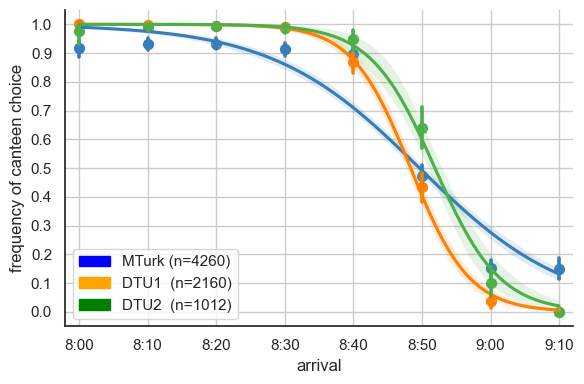

In [9]:
pal = dict(dfm='#377eb8', dfd1='#ff7f00', dfd2='#4daf4a') # taken from https://gist.github.com/thriveth/8560036
g = sns.lmplot(x="arrival", y="choice", hue="group", data=df, palette=pal, 
               logistic=True, ci=95, n_boot=10000, x_estimator=np.mean, x_ci="ci",
               y_jitter=.2, legend=False, height=4, aspect=1.5)

#plt.setp(g.lines, alpha=1) # setting translucency of CI to zero
g.set(xlim=(-2, 72))
g.set(ylabel='frequency of canteen choice')
g.set(xticks=[0,10,20,30,40,50,60,70], yticks=[0, .1,.2,.3,.4,.5,.6,.7,.8,.9, 1])
g.set(xticklabels = ["8:00", "8:10", "8:20", "8:30", "8:40", "8:50", "9:00", "9:10"])

# make my own legend:
name_to_color = {
    'MTurk (n=4260)': 'blue',
    'DTU1  (n=2160)': 'orange',
    'DTU2  (n=1012)': 'green',
}
patches = [patch.Patch(color=v, label=k) for k,v in name_to_color.items()]
plt.legend(handles=patches, loc='lower left')
plt.grid()
plt.tight_layout()

plt.rcParams["font.family"] = "sans-serif"
PLOTS_DIR = '../plots'

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

plt.savefig(os.path.join(PLOTS_DIR, 'fig1.png'),
            bbox_inches='tight', transparent=True, dpi=300)
#plt.savefig(os.path.join(PLOTS_DIR, 'fig1_logit.pdf'), transparent=True, dpi=300)
sns.despine()